<a href="https://colab.research.google.com/github/alberba/Aprendizaje-Autom-tico/blob/main/18_Practica2/informe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Practica 2
## Autores: Angel Jimenez y Albert Salom

In [1]:
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
from tqdm.auto import tqdm
from collections import OrderedDict, defaultdict
from pathlib import Path
from torchvision.ops.boxes import masks_to_boxes
from torch.utils.data import Dataset, DataLoader
from IPython import display
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchvision import tv_tensors
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes

import os
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import scipy.io
import torch
import pylab as pl
import torch.optim as optim
import torchvision
import random

TRAIN_MODE = False


# Introducción

En esta práctica veremos cómo con diferentes modelos a partir del fine tunning y con un modelo creado de cero podemos obtener un modelo que sea capaz de clasificar imágenes entre 2 clases. En nuestro caso, las clases seleccionados son buddha y dalmatian.

A primera vista, creemos que los modelos serán capaces de clasificar con facilidad entre las 2 clases, ya que creemos que las imágenes de buddha y dalmatian no comparten muchos patrones. Sin embargo, es posible que en el modelo creado de cero tenga un peor rendimiento, ya que los modelos ya preentrenados han sido ajustados con un gran númeroo de imágenes. En el caso de nuestro modelo, podrían ser insuficientes para obtener un buen rendimiento.

## Data Augmentation

En primera instancia, tenemos que realizar un data augmentation para aumentar el número de imágenes de entrenamiento, ya que las 2 clases tienen un número muy reducido de imagenes, en este caso 152 imágenes. Para ello, a partir de las imagenes originales, se aplicarán diferentes transformaciones.

In [10]:
!wget https://github.com/alberbaaaa/archivo_Practica_AA/raw/refs/heads/main/archivos.zip
!unzip archivos.zip

--2025-01-12 22:52:56--  https://github.com/alberbaaaa/archivo_Practica_AA/raw/refs/heads/main/archivos.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/alberbaaaa/archivo_Practica_AA/refs/heads/main/archivos.zip [following]
--2025-01-12 22:52:57--  https://media.githubusercontent.com/media/alberbaaaa/archivo_Practica_AA/refs/heads/main/archivos.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 946896971 (903M) [application/zip]
Saving to: ‘archivos.zip’

archivos.zip        100%[===================>] 903.03M   112MB/s    in 7.1s    

2025-01-12 22:54:04 (127 MB/s) - ‘ar

In [94]:

# Ruta a la carpeta principal donde se encuentran las 2 clases
# Ejemplo: dataPractica/caltech101/101_ObjectCategories
ruta_base = 'dataPractica/caltech101/101_ObjectCategories'

# Lista de clases de interés
clases_de_interes = ['buddha', 'dalmatian']

# Definir cuántas versiones nuevas quieres crear por cada imagen original
num_nuevas_por_imagen = 2

# Definimos las transformaciones de data augmentation que generan imágenes realistas
# para buddha y dalmatian. Evitamos volteos verticales o rotaciones extremas.
transformaciones_aumentadas = transforms.Compose([
    # 1) Ajuste del tamaño a 256x256
    transforms.Resize((256, 256)),

    # 2) Recorte aleatorio para 224x224, simulando diferentes encuadres/zoom
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),       # rango de escalado
        ratio=(0.9, 1.1)        # rango de aspecto (ancho x alto)
    ),

    # 3) Rotación aleatoria moderada (±15 grados)
    transforms.RandomRotation(degrees=30),

    # 4) Flip horizontal aleatorio (probabilidad 0.5)
    transforms.RandomHorizontalFlip(p=1),

    # 5) Ajustes de color para simular distintas condiciones de iluminación
    transforms.ColorJitter(
        brightness=0.5,
        contrast=0.2,
        saturation=0.4,
        hue=0.05
    ),

    transforms.ToTensor(),  # Convertir a tensor
])

num_buddhas_originales = 85
num_dalmatians_originales = 67

# ---- CREACIÓN DE NUEVAS IMÁGENES ----
for clase in clases_de_interes:
    # Carpeta de origen (donde están las imágenes originales)
    carpeta_origen = os.path.join(ruta_base, clase).replace('\\', '/')

    # Lo guardamos en la misma carpeta
    carpeta_destino = carpeta_origen

    if clase == 'buddha':
        indice = num_buddhas_originales
    else:
        indice = num_dalmatians_originales

    # Listar las imágenes originales
    imagenes = [
        f for f in os.listdir(carpeta_origen)
        if os.path.isfile(os.path.join(carpeta_origen, f))
           and f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ][:indice] # Limitar el número de imágenes a las originales

    print(f"\nClase: {clase}")
    print(f"  Imágenes originales: {len(imagenes)}")


    indice += 1
    # Generar nuevas imágenes
    contador_nuevas = 0
    for nombre_imagen in imagenes:
        ruta_imagen = os.path.join(carpeta_origen, nombre_imagen)

        # Abrir la imagen original en modo RGB
        imagen_original = Image.open(ruta_imagen).convert('RGB')

        # Crear 'num_nuevas_por_imagen' transformaciones diferentes
        for i in range(num_nuevas_por_imagen):
            # Aplicar transformaciones
            imagen_trans = transformaciones_aumentadas(imagen_original)

            # En caso de que la transformación devuelva un tensor, convertimos a PIL
            if isinstance(imagen_trans, torch.Tensor):
                imagen_trans = transforms.ToPILImage()(imagen_trans)

            # Definir el nombre para la imagen aumentada
            nombre_sin_ext, ext = os.path.splitext(nombre_imagen)
            num_ceros = max(0, 4 - len(str(indice)))
            indice_formateado = f"{'0' * num_ceros}{indice}"
            nuevo_nombre = f"image_{indice_formateado}{ext}"

            # Guardar la imagen nueva en la carpeta destino
            ruta_salida = os.path.join(carpeta_destino, nuevo_nombre)
            imagen_trans.save(ruta_salida)

            indice += 1
            contador_nuevas += 1

    print(f"  Imágenes aumentadas generadas: {contador_nuevas}")
    print(f"  Guardadas en: {carpeta_destino}")




Clase: buddha
  Imágenes originales: 85
  Imágenes aumentadas generadas: 170
  Guardadas en: dataPractica/caltech101/101_ObjectCategories/buddha

Clase: dalmatian
  Imágenes originales: 67
  Imágenes aumentadas generadas: 134
  Guardadas en: dataPractica/caltech101/101_ObjectCategories/dalmatian


## Load Dataset

Una vez aumentado el número de imágenes, cargaremos el dataset y lo dividiremos en 2 conjuntos, uno de entrenamiento y otro de test. En cuanto al tamaño de los batches, se ha seleccionado un tamaño de 4, ya que creemos que es un tamaño adecuado para este entrenamiento.

In [95]:
EPOCHS = 5
BATCH_SIZE = 4

Total de imágenes: 456
Tamaño del lote de imágenes: torch.Size([4, 3, 224, 224])
Etiquetas: tensor([0, 0, 0, 0])


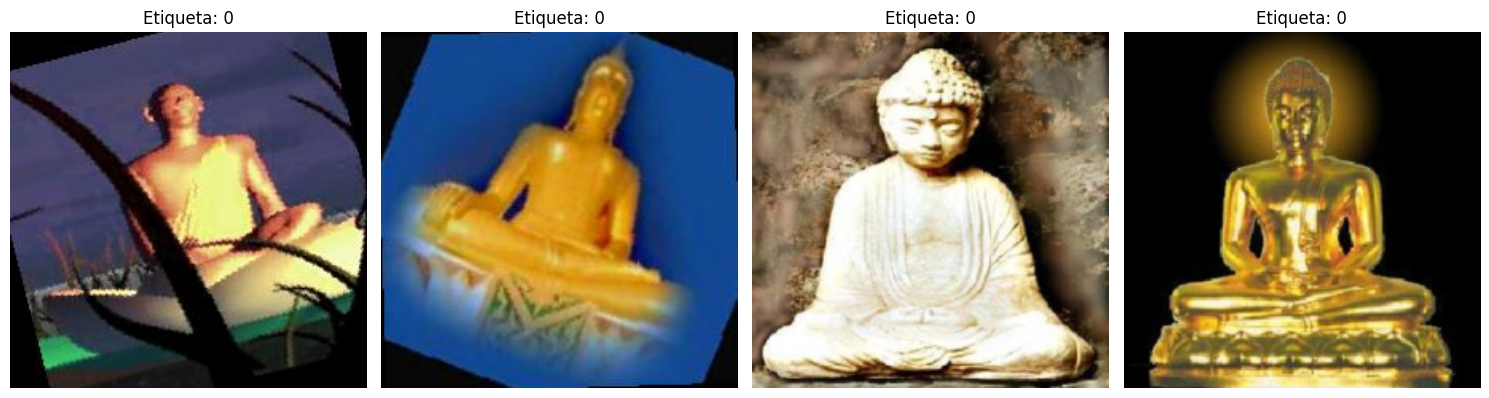

In [96]:
# Definir las transformaciones para el dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalizar con la media y desviación estándar para cada canal de color
    transforms.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.])
])

# Cargar el dataset con ImageFolder
dataset = datasets.ImageFolder(
    root=ruta_base,
    transform=transform
)

print(f"Total de imágenes: {len(dataset)}")

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Crear los data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Probar el dataset cargando un lote
for images, labels in train_loader:
    print(f"Tamaño del lote de imágenes: {images.shape}")
    print(f"Etiquetas: {labels}")

    # Calcular el número de filas necesarias
    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols  # Redondear hacia arriba

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

    for i, (img, ax) in enumerate(zip(images, axes)):
        img = transforms.ToPILImage()(img)  # Convertir el tensor a imagen PIL
        ax.imshow(img, interpolation='bilinear')  # Mejor interpolación
        ax.set_title(f"Etiqueta: {labels[i].item()}")
        ax.axis("off")

    # Ocultar los ejes sobrantes si hay menos imágenes que espacios
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()  # Ajustar los espacios en el plot
    plt.show()
    break  # Salir después de mostrar un lote

# Clasificación de imágenes

## ALexNet



In [97]:
# Cargar el modelo AlexNet preentrenado
alexNet = models.alexnet(weights="IMAGENET1K_V1")

# Congelar todos los parámetros para el Fine Tuning
for param in alexNet.parameters():
    param.requires_grad = False

alexNet.classifier[6] = nn.Linear(alexNet.classifier[6].in_features, len(clases_de_interes))

# Definir el criterio (función de pérdida) y el optimizador
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(alexNet.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = alexNet.to(device)

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

In [98]:
# Función para entrenar y evaluar cada uno de los modelos
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, loss_fn):

    for t in tqdm(range(EPOCHS), desc="Èpoques"):
        batch_loss = 0
        batch_acc = 0

        i_batch = 1
        # Iteram els batches.
        for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"):
            model.train()  # Posam el model a mode entrenament.

            optimizer.zero_grad()

            # 1. PREDICCIÓ

            y_pred = model(x.to(device))

            # 2. CALCUL DE LA PÈRDUA
            # Computa la pèrdua: l'error de predicció vs el valor correcte
            # Es guarda la pèrdua en un array per futures visualitzacions

            loss = loss_fn(y_pred, y.to(device))

            #3. GRADIENT
            model.zero_grad()
            loss.backward()

            # Actualitza els pesos utilitzant l'algorisme d'actualització
            #4. OPTIMITZACIO
            with torch.no_grad():
                optimizer.step()

            # 5. EVALUAM EL MODEL
            model.eval()  # Mode avaluació de la xarxa

            y_pred = model(x.to(device))
            batch_loss += (loss_fn(y_pred, y.to(device)).detach().cpu())

            y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
            batch_acc += accuracy_score(y.cpu().numpy(), y_pred_class)


        running_loss.append(batch_loss / (i_batch + 1))
        running_acc.append(batch_acc / (i_batch + 1))

        batch_test_loss = 0
        batch_test_acc = 0

        model.eval()
        for i_batch, (x, y) in enumerate(test_loader):

            y_pred = model(x.to(device))
            batch_test_loss += (loss_fn(y_pred, y.to(device)).detach().cpu())
            y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
            acc = accuracy_score(y.cpu().numpy(), y_pred_class)
            batch_test_acc += acc

        running_test_loss.append(batch_test_loss / (i_batch + 1))
        running_test_acc.append(batch_test_acc / (i_batch + 1))

    return running_loss, running_acc, running_test_loss, running_test_acc

if TRAIN_MODE:
    running_loss, running_acc, running_test_loss, running_test_acc = train_and_evaluate_model(model, train_loader, test_loader, optimizer, loss_fn)
    torch.save(model.state_dict(), 'alexnet.pth')

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

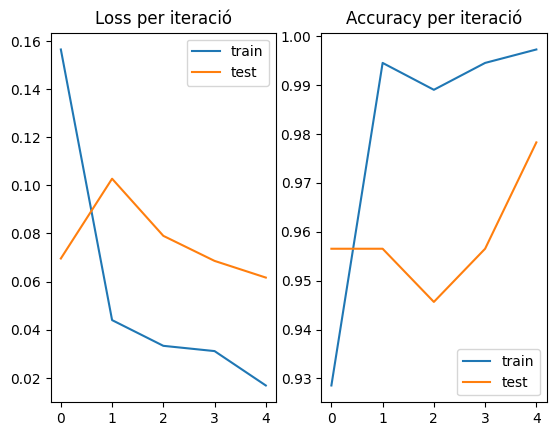

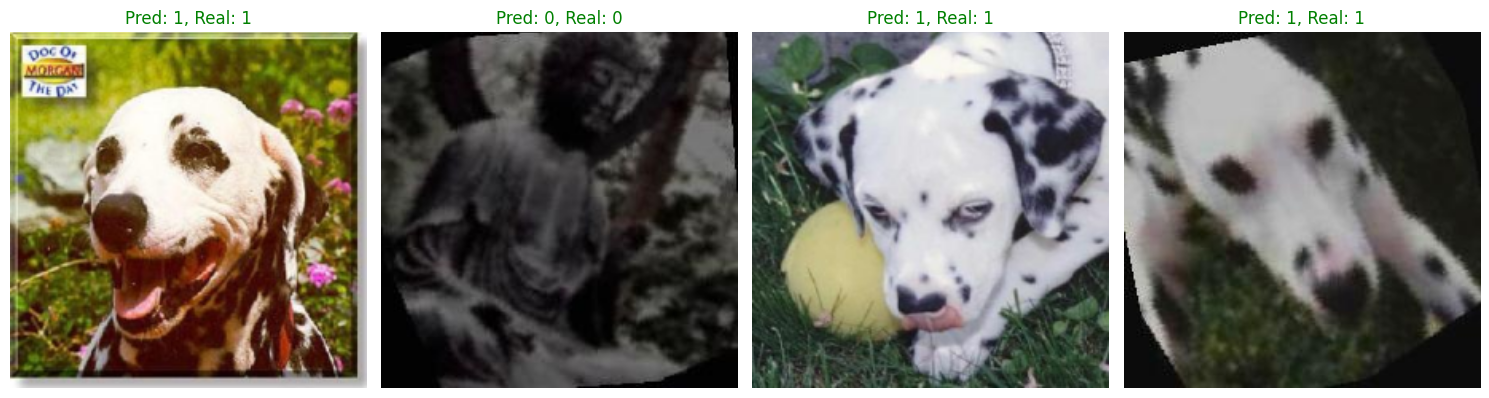

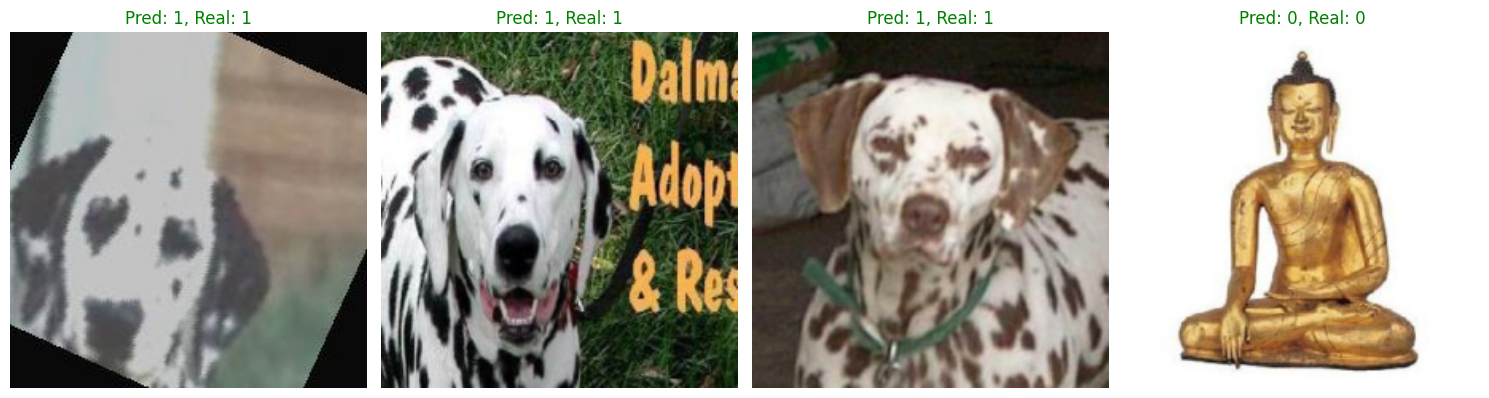

In [99]:
# Función para mostrar la evaluación del modelo a partir de gráficos y ejemplos visuales
def mostrar_evaluacion_modelo(model, test_loader, running_loss, running_test_loss, running_acc, running_test_acc, model_save):

    if not TRAIN_MODE:
        model.load_state_dict(torch.load(f"{model_save}.pth"))
        model.eval()

        batch_test_loss = 0
        batch_test_acc = 0
        for i_batch, (x, y) in enumerate(test_loader):

            y_pred = model(x.to(device))
            batch_test_loss += (loss_fn(y_pred, y.to(device)).detach().cpu())
            y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
            acc = accuracy_score(y.cpu().numpy(), y_pred_class)
            batch_test_acc += acc

        print(f"Test loss de {model_save}: {(batch_test_loss / (i_batch + 1)).item():.4f}")
        print(f"Test accuracy de {model_save}: {batch_test_acc / (i_batch + 1):.3f}")

    else:
        # MOSTRAMOS GRÁFICAMENTE LA EVALUACIÓN DEL MODELO
        plt.subplot(1,2,1)
        plt.title("Loss per iteració")
        plt.plot([loss.cpu().item() for loss in running_loss], label="train")
        plt.plot([loss.cpu().item() for loss in running_test_loss], label="test")
        plt.legend()

        plt.subplot(1,2,2)
        plt.title("Accuracy per iteració")
        plt.plot(running_acc, label="train")
        plt.plot(running_test_acc, label="test")
        plt.legend()
        plt.show()

    ## MOSTRAMOS EJEMPLOS VISUALES
    #  Iterar sobre 2 batches de test
    num_batches_to_display = 2
    batches_displayed = 0

    test_list = list(test_loader)

    while batches_displayed < num_batches_to_display:
        images, labels = random.choice(test_list)

        # Predicción
        y_pred = model(images.to(device))
        y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()

        # Calcular el número de filas necesarias
        num_images = len(images)
        num_cols = 4
        num_rows = (num_images + num_cols - 1) // num_cols  # Redondear hacia arriba

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
        axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

        for i, (img, ax) in enumerate(zip(images, axes)):
            img = transforms.ToPILImage()(img)  # Convertir el tensor a imagen PIL
            ax.imshow(img, interpolation='bilinear')  # Mejor interpolación
            if y_pred_class[i] == labels[i].item():
                ax.set_title(f"Pred: {y_pred_class[i]}, Real: {labels[i].item()}", color="green")
            else:
                ax.set_title(f"Pred: {y_pred_class[i]}, Real: {labels[i].item()}", color="red")
            ax.axis("off")

        # Ocultar los ejes sobrantes si hay menos imágenes que espacios
        for ax in axes[num_images:]:
            ax.axis("off")

        plt.tight_layout()  # Ajustar los espacios en el plot
        plt.show()

        batches_displayed += 1

mostrar_evaluacion_modelo(model, test_loader, running_loss, running_test_loss, running_acc, running_test_acc, "alexnet")

Como se puede observar, cumple las expectativas que teníamos, ya que en muchas de las ejecuciones, el modelo ha obtenido un accuracy del 95-100%. En cuanto a la pérdida, también ha sido muy baja, en torno a 0.00-0.02.

Esto puede llegar a hacer ver que el modelo ha sido sobreajustado, ya que el accuracy en el conjunto de test es muy alto. Sin embargo, hay que tener en cuenta que partimos de un modelo entrenado con un gran número de imágenes, por lo que es normal que trabajando con un número reducido de imágenes y que son 2 clases muy diferenciadas, el modelo obtenga un rendimiento tan alto.

## VGG 16

En el caso de las VGG, hemos decidido que vamos a usar este modelo antes que el de VGG-19. Aunque ambos nos servirían, hemos visto que el VGG 19 es más óptimo para clases con mayor número de muestras, mientras que el VGG-16 funciona mejor para clases con pocas muestras como es nuestro caso.

En cuanto a los pesos, hemos usado el de ImageNet con el modulo clasificador.

In [100]:
# Cargar el modelo VGG16 preentrenado
model_vgg = models.vgg16(weights='IMAGENET1K_V1', progress=True)

# Congelar todos los parámetros para el Fine Tuning
for param in model_vgg.parameters():
    param.requires_grad = False

model_vgg.classifier[6] = nn.Linear(model_vgg.classifier[6].in_features, len(clases_de_interes))

# Definir el criterio (función de pérdida) y el optimizador
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(model_vgg.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_vgg.to(device)

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

In [101]:
if TRAIN_MODE:
    running_loss, running_acc, running_test_loss, running_test_acc = train_and_evaluate_model(model, train_loader, test_loader, optimizer, loss_fn)
    torch.save(model.state_dict(), 'vgg16.pth')

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

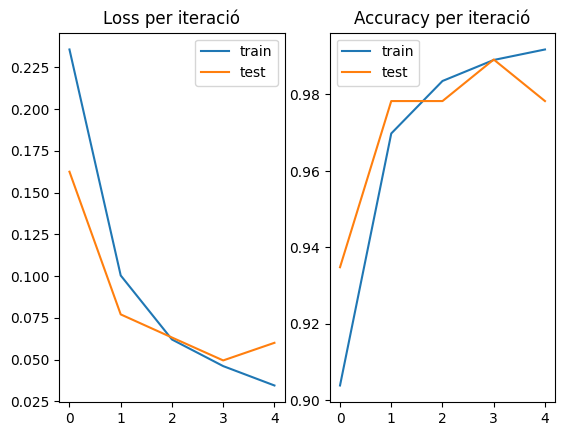

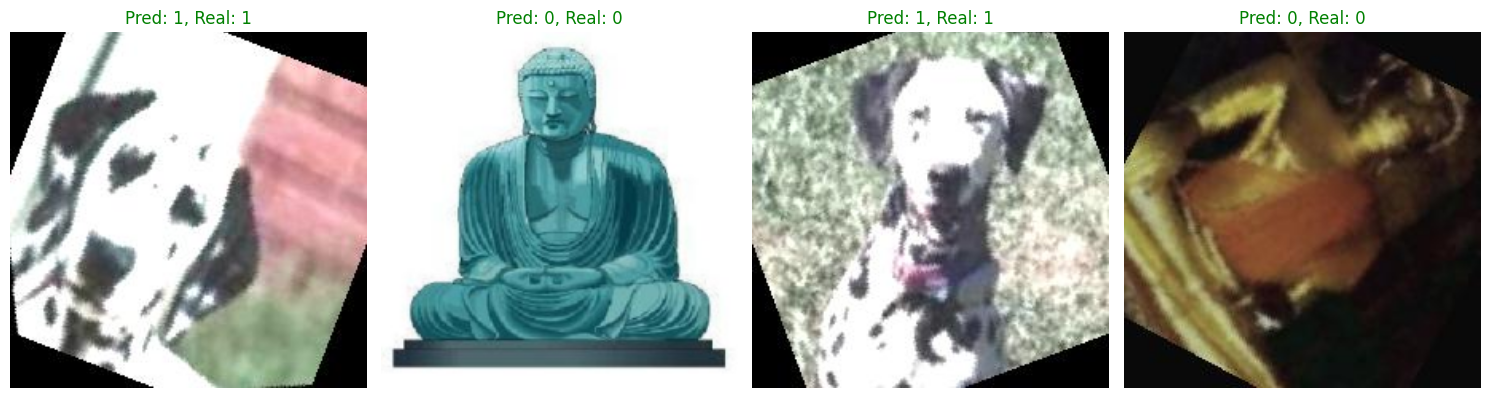

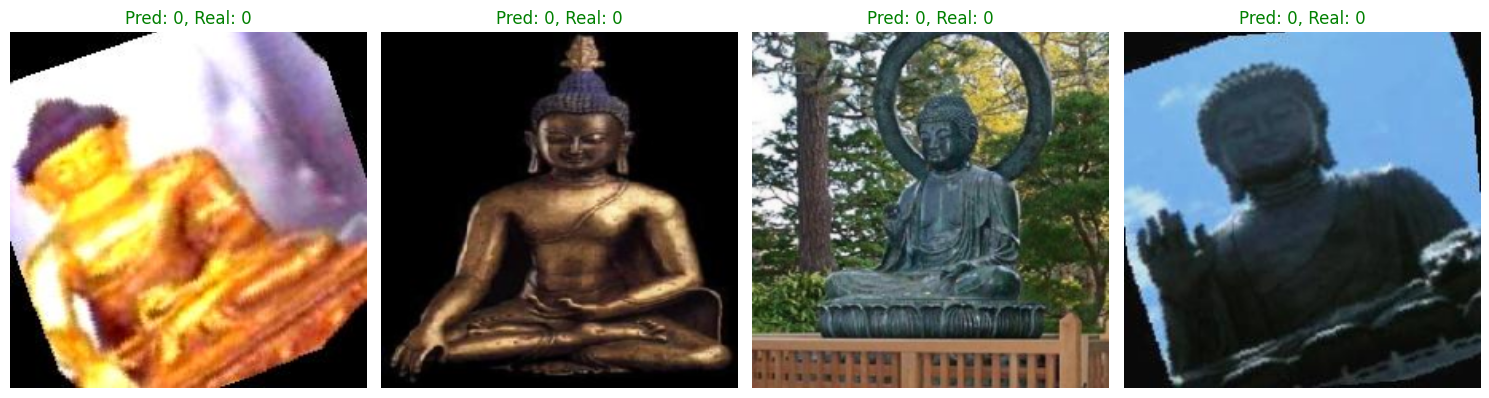

In [102]:
mostrar_evaluacion_modelo(model, test_loader, running_loss, running_test_loss, running_acc, running_test_acc, "vgg16")

En cuanto al vgg, vemos que los resultados son bastante parecidos a los de AlexNet, ya que el accuracy en el conjunto de test es muy alto, en torno al 95-100%. En cuanto a la pérdida, también es muy baja, en torno a 0.00-0.02.

Por otro lado, en cuanto al tiempo de entrenamiento, hemos visto que es mayor que el de AlexNet, ya que el modelo es más complejo y tiene más capas. Igualmente, el tiempo de entrenamiento es muy bajo.

### RESNET 18

In [103]:
# Cargar ResNet18 preentrenado
model_resnet = models.resnet18(weights='IMAGENET1K_V1', progress=True)

# Congelar todos los parámetros para el Fine Tuning
for param in model_resnet.parameters():
    param.requires_grad = False

# Modificar la última capa completamente conectada para nuestras clases
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, len(clases_de_interes))

# Definir el criterio (función de pérdida) y el optimizador
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(model_resnet.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_resnet.to(device)

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

In [104]:
if TRAIN_MODE:
    running_loss, running_acc, running_test_loss, running_test_acc = train_and_evaluate_model(model, train_loader, test_loader, optimizer, loss_fn)
    torch.save(model.state_dict(), 'resnet18.pth')

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

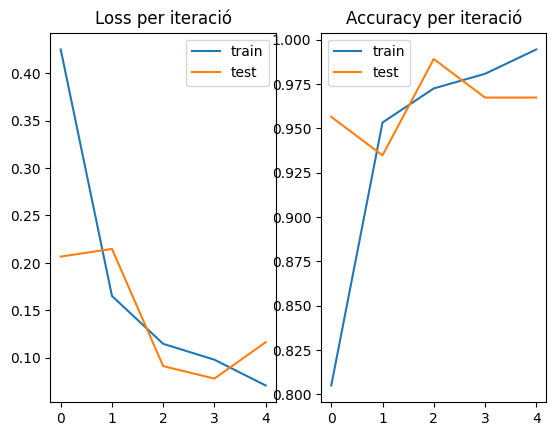

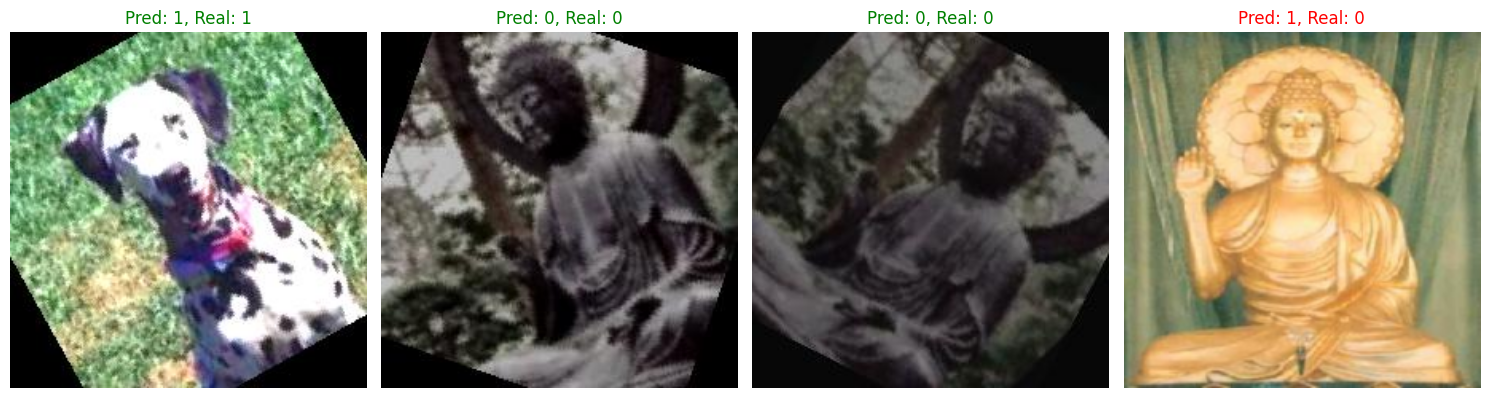

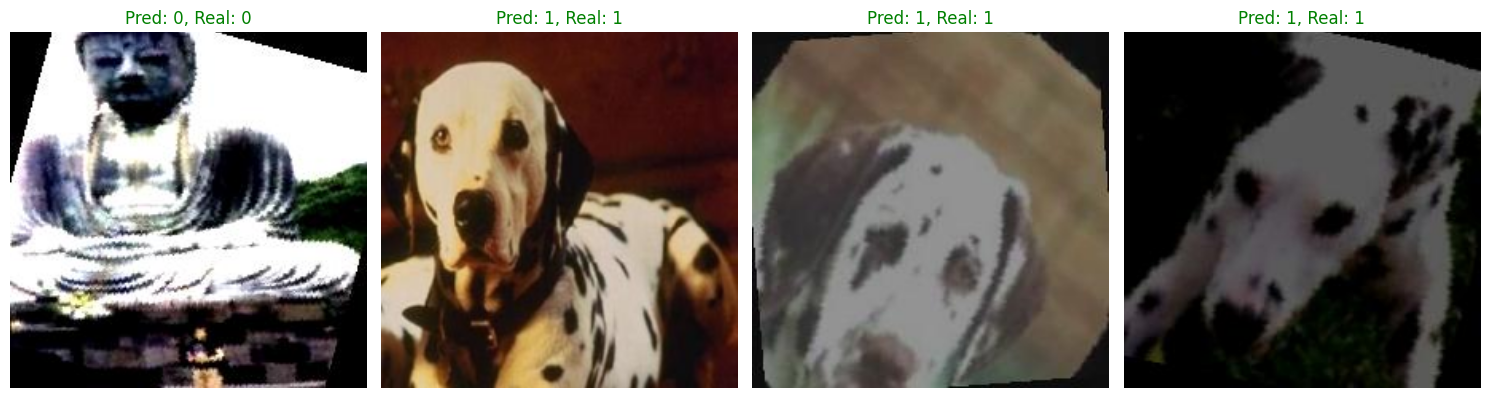

In [105]:
mostrar_evaluacion_modelo(model, test_loader, running_loss, running_test_loss, running_acc, running_test_acc, "resnet18")

Datos muy parecidos a los de los modelos anteriores, con unos valores de accuracy y perdida muy buenos. En cuanto al tiempo de entrenamiento, es parecido al del AlexNet.

### CNN PROPIO PERSONALIZADO

En cuanto al modelo creado desde cero, hemos decidido crear un modelo CNN propio, con 3 capas convolucionales y 2 capas fully connected. En cuanto a las capas convolucionales, hemos usado 32, 64 y 128 filtros respectivamente.

In [106]:
class CustomCNN(nn.Module):
    def __init__(self, num_clases):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce a 112x112

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce a 56x56

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce a 28x28
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),  # Ajustar según entrada
            nn.ReLU(),
            nn.Dropout(0.5),  # Congelar el 50% de las neuronas, para evitar overfitting
            nn.Linear(512, num_clases)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Inicializar el modelo
num_clases = len(clases_de_interes)
model_cnn_custom = CustomCNN(num_clases)

# Definir el criterio (función de pérdida) y el optimizador
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(model_cnn_custom.parameters(), lr=learning_rate)

# Mover a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_cnn_custom.to(device)

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

In [107]:
EPOCHS = 10
if TRAIN_MODE:
    running_loss, running_acc, running_test_loss, running_test_acc = train_and_evaluate_model(model, train_loader, test_loader, optimizer, loss_fn)
    torch.save(model.state_dict(), 'cnn_propio.pth')

Èpoques:   0%|          | 0/10 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

Batches (Època 6): 0it [00:00, ?it/s]

Batches (Època 7): 0it [00:00, ?it/s]

Batches (Època 8): 0it [00:00, ?it/s]

Batches (Època 9): 0it [00:00, ?it/s]

Batches (Època 10): 0it [00:00, ?it/s]

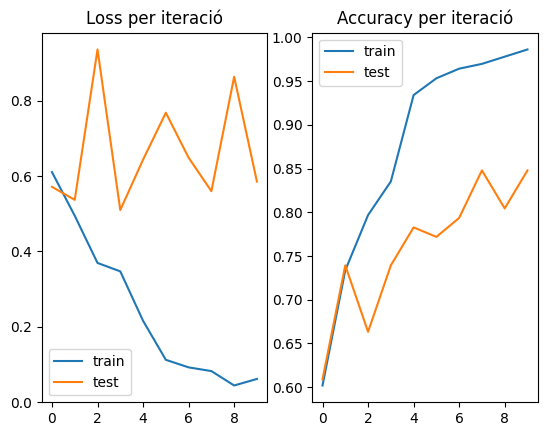

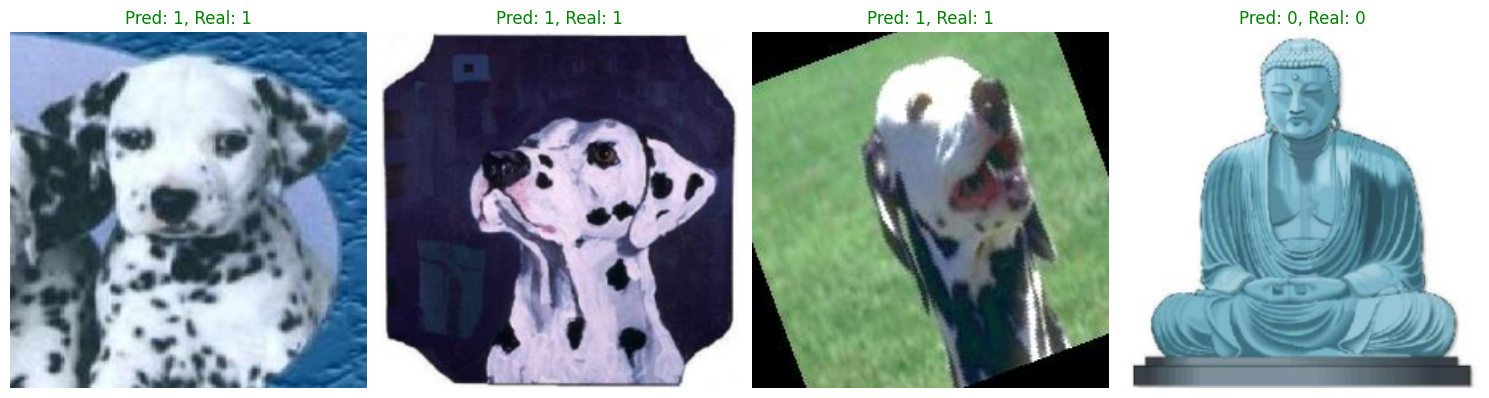

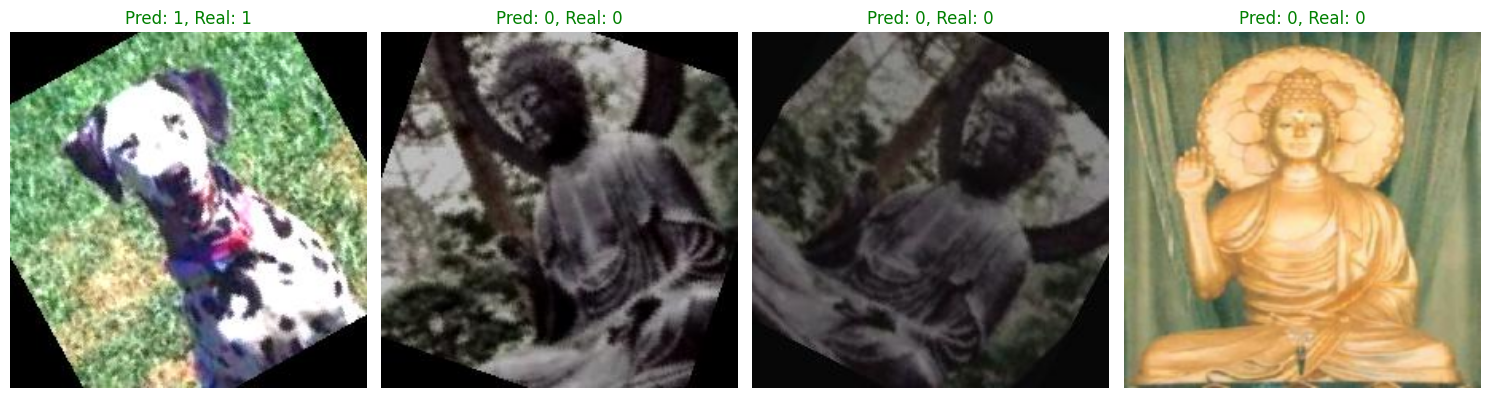

In [108]:
mostrar_evaluacion_modelo(model, test_loader, running_loss, running_test_loss, running_acc, running_test_acc, "cnn_propio")

# Detección

### YOLO (Pendiente decidir versión)

In [109]:
!pip install ultralytics

In [110]:
from ultralytics import YOLO

if TRAIN_MODE:
    model = YOLO("yolov5n.pt")
    model.train(data="/content/datasets/BuddhaDalmatian-5/data.yaml", epochs=10, imgsz=256)
else:
    model = YOLO("yolov5_entrenado.pt")

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 5.31M/5.31M [00:00<00:00, 81.9MB/s]


Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5n.pt, data=/content/datasets/BuddhaDalmatian-5/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 105MB/s]
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context:

AMP: checks passed ✅


train: Scanning /content/datasets/BuddhaDalmatian-5/train/labels... 319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 319/319 [00:00<00:00, 882.08it/s]

train: New cache created: /content/datasets/BuddhaDalmatian-5/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/BuddhaDalmatian-5/valid/labels... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 494.20it/s]

val: New cache created: /content/datasets/BuddhaDalmatian-5/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/10      13.1G     0.6986      2.162      1.173         16        256: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69      0.896      0.764      0.921       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/10       9.1G     0.5817     0.9416      1.088         15        256: 100%|██████████| 20/20 [00:03<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69      0.963      0.943      0.975      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/10       9.1G     0.6219     0.8089      1.079         15        256: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69      0.829      0.862      0.942      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/10       9.1G     0.6442     0.7802        1.1         15        256: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69      0.743      0.921      0.965      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/10       9.1G     0.6278     0.7198      1.079         15        256: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69      0.807      0.718      0.851      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/10       9.1G     0.6212     0.7155      1.115         15        256: 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69      0.978      0.964      0.989      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/10       9.1G     0.5711      0.654      1.043         15        256: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69      0.969      0.957      0.977       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/10      9.09G      0.538      0.614      1.042         15        256: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69      0.979      0.938      0.982      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/10      9.09G     0.4859     0.5374      1.005         15        256: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69       0.99      0.971      0.993      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/ultralytics/utils/loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/10      9.09G       0.45     0.5538     0.9892         15        256: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      

                   all         69         69      0.978      0.971      0.991      0.807

10 epochs completed in 0.013 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

YOLOv5n summary (fused): 193 layers, 2,503,334 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


                   all         69         69       0.99      0.971      0.993       0.81
                buddha         35         35       0.99      0.943      0.991      0.766
             dalmatian         34         34      0.991          1      0.995      0.853
Speed: 0.0ms preprocess, 2.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train


Como se puede observar, el YOLO nos da muy buenos resultados, además siendo muy rápido.

In [111]:
import matplotlib.pyplot as plt
results = model("/content/datasets/BuddhaDalmatian-5/test/images/")


image 1/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0006_jpg.rf.6e0dc6633f83a6d2fdccb05500d54fad.jpg: 256x256 1 dalmatian, 10.1ms
image 2/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0007_jpg.rf.e1ca13133d66e1203ab893fc3b82135b.jpg: 256x256 1 dalmatian, 6.8ms
image 3/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0008_jpg.rf.b01d9344b78a9cde82e0186f80ad9f2d.jpg: 256x256 1 dalmatian, 6.6ms
image 4/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0010_jpg.rf.ed081ce0b34347e8ae35b4138480ee90.jpg: 256x256 1 buddha, 7.2ms
image 5/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0019_jpg.rf.0d5acec69f1c82c9e89fbbc40cedadb0.jpg: 256x256 2 buddhas, 16.3ms
image 6/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0024_jpg.rf.6de27deba0ca814db36bbd7c5216e9f9.jpg: 256x256 1 dalmatian, 11.1ms


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.10/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

image 7/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0026_jpg.rf.d17f88be3e34fc3530e2fcc00ba55cd1.jpg: 256x256 1 buddha, 10.5ms
image 8/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0030_jpg.rf.0f812bb8a1b1a55bb086748311baeeea.jpg: 256x256 1 buddha, 7.3ms
image 9/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0033_jpg.rf.8604bcc49d1233f124cf276349797d10.jpg: 256x256 1 buddha, 8.1ms
image 10/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0034_jpg.rf.3f1e828cc849087a9f32b9fcb32d7c37.jpg: 256x256 1 buddha, 7.9ms
image 11/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0040_jpg.rf.15465eb3ac0da053f16bd9f9baf21a85.jpg: 256x256 1 buddha, 8.5ms
image 12/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0043_jpg.rf.aa7de304fc260f7b15c036dca36cd20a.jpg: 256x256 1 dalmatian, 7.5ms
image 13/68 /content/datasets/BuddhaDalmatian-5/test/images/image_0045_jpg.rf.0c169deb5a09b43d6c9a9d1c78f57b7e.jpg: 256x256 1 dalmatian, 8.1ms
image 14/68 /con

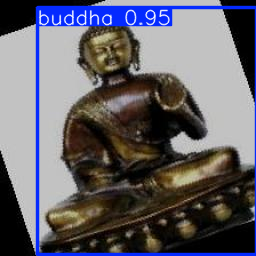

In [112]:
random.choice(results).show()

En cuanto a las imagenes, vemos como el YOLO acierta con soldura, con un indice de confianza en cada imagen muy alto.

## Mask-RCNN

Hemos decidido usar el modelo Mask-RCNN ya que es un modelo que ya viene con la detección de objetos y segmentación de instancias. En cuanto a la arquitectura, hemos decidido usar la arquitectura ResNet50, ya que es la mas común y la que mejor resultados da.

### Preparación de los datos

Para poder trabajar con Mask-RCNN, tenemos que adaptar el dataset al formato pedido por el modelo. Para ello, primeramente tendremos que sacar las máscaras de las imágenes, ya que el modelo necesita las máscaras para poder segmentar las instancias.

In [2]:
# Extraído con ayuda de ChatGPT
def process_images_and_masks(base_dir_images, base_dir_annotations):
    """
    Procesa imágenes y máscaras de las clases 'buddha' y 'dalmatian'.

    Args:
        base_dir_images (str): Ruta base de las imágenes (101_ObjectCategories).
        base_dir_annotations (str): Ruta base de las anotaciones.

    Returns:
        list: Lista de imágenes procesadas como arrays de NumPy.
        list: Lista de máscaras procesadas como arrays de NumPy.
    """
    classes_to_process = {'buddha': 1, 'dalmatian': 2}
    image_list = []
    mask_list = []
    class_list = []

    for class_name, class_id in classes_to_process.items():
        # Rutas de las subcarpetas
        class_images_dir = os.path.join(base_dir_images, class_name)
        class_annotations_dir = os.path.join(base_dir_annotations, class_name)

        # Verifica si las carpetas existen
        if not os.path.isdir(class_images_dir) or not os.path.isdir(class_annotations_dir):
            print(f"Carpeta no encontrada: {class_name}")
            continue

        # Procesar las imágenes y las anotaciones
        for annotation_file in os.listdir(class_annotations_dir):
            if annotation_file.endswith('.mat'):
                annotation_path = os.path.join(class_annotations_dir, annotation_file)
                annotation_id = os.path.splitext(annotation_file)[0].split('_')[-1]

                # Ruta de la imagen correspondiente
                image_file = f"image_{annotation_id}.jpg"
                image_path = os.path.join(class_images_dir, image_file)

                if not os.path.exists(image_path):
                    print(f"Imagen no encontrada para {annotation_file}")
                    continue

                # Cargar la anotación
                mat_data = scipy.io.loadmat(annotation_path)
                if 'obj_contour' not in mat_data:
                    print(f"'obj_contour' no encontrada en {annotation_file}")
                    continue

                obj_contour = mat_data['obj_contour']  # Contorno de la máscara

                # Cargar la imagen
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error al cargar la imagen {image_path}")
                    continue

                # Crear una máscara vacía del mismo tamaño que la imagen
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
                boxcoord = mat_data['box_coord'].flatten()

                # Dibujar el contorno en la máscara
                contour_points = np.transpose(obj_contour)  # Shape (Y, 2)
                contour_points[:, 0] += boxcoord[2]  # Ajustar X según x0 del bounding box
                contour_points[:, 1] += boxcoord[0]  # Ajustar Y según y0 del bounding box
                contour_points = contour_points.astype(np.int32)  # Asegurar tipo correcto

                cv2.drawContours(mask, [contour_points], contourIdx=-1, color=1, thickness=-1)
                #cv2.drawContours(image, [contour_points], contourIdx=-1, color=1, thickness=-1)

                # Mostrar la imagen
                # cv2_imshow(image)
                # cv2.waitKey(0)
                # cv2.destroyAllWindows()

                # Agregar la imagen y la máscara a las listas
                image_list.append(image)
                mask_list.append(mask)
                class_list.append(class_id)

    return image_list, mask_list, class_list


# Descargamos el dataset Caltech101
dataset = datasets.Caltech101(root='./dataAux', download=True, target_type='annotation')

base_dir_images = "./dataAux/caltech101/101_ObjectCategories"
base_dir_annotations = "./dataAux/caltech101/Annotations"
images, masks, classes = process_images_and_masks(base_dir_images, base_dir_annotations)
print(f"Procesadas {len(images)} imágenes y {len(masks)} máscaras.")

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=ed48107e-14c4-40d4-95e4-d06ebc730629
To: /content/dataAux/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:03<00:00, 33.2MB/s]


Extracting ./dataAux/caltech101/101_ObjectCategories.tar.gz to ./dataAux/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=e6d6f09b-4996-4399-8d1f-6dd691d1d446
To: /content/dataAux/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 25.1MB/s]


Extracting ./dataAux/caltech101/Annotations.tar to ./dataAux/caltech101
Procesadas 152 imágenes y 152 máscaras.


Una vez hemos extraído las máscaras, procederemos a hacer un data augmentation de este conjunto de imagene

In [3]:
def augment_data(images, masks, classes):
    """
    Realiza aumentos de datos en las imágenes y máscaras.

    Args:
        images (list): Lista de imágenes como arrays de NumPy.
        masks (list): Lista de máscaras como arrays de NumPy.

    Returns:
        list: Lista de imágenes aumentadas como arrays de NumPy.
        list: Lista de máscaras aumentadas como arrays de NumPy.
    """
    augmented_images = []
    augmented_masks = []
    augmented_classes = []

    common_transform = [
        # 1) Ajuste del tamaño a 256x256
        transforms.Resize((256, 256)),

        # 2) Recorte aleatorio para 224x224, simulando diferentes encuadres/zoom
        transforms.RandomResizedCrop(
            size=256,
            scale=(0.8, 1.0),       # rango de escalado
            ratio=(0.9, 1.1)        # rango de aspecto (ancho x alto)
        ),

        # 3) Rotación aleatoria moderada (±15 grados)
        transforms.RandomRotation(degrees=30),

        # 4) Flip horizontal aleatorio (probabilidad 0.5)
        transforms.RandomHorizontalFlip(p=1),
    ]

    # Transformaciones para imágenes
    img_transform = transforms.Compose(common_transform + [

        # 5) Ajustes de color para simular distintas condiciones de iluminación
        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.2,
            saturation=0.4,
            hue=0.05
        ),
    ])

    mask_transform = transforms.Compose(common_transform)

    num_nuevas_por_imagen = 2

    # Iteración obtenida con ayuda de ChatGPT
    for img, mask, img_class in zip(images, masks, classes):
        # Convertir la imagen y la máscara a PIL
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        mask_pil = Image.fromarray(mask)

        for i in range(num_nuevas_por_imagen):

            # Aplicar las transformaciones
            seed = random.randint(0, 2**32)  # Para asegurar que las mismas transformaciones se aplican a ambos
            random.seed(seed)
            augmented_img = img_transform(img_pil)
            random.seed(seed)
            augmented_mask = mask_transform(mask_pil)

            # Convertir de nuevo a arrays de NumPy
            augmented_images.append(np.array(augmented_img))
            augmented_masks.append(np.array(augmented_mask))
            augmented_classes.append(img_class)

    return augmented_images, augmented_masks, augmented_classes

augmented_images, augmented_masks, augmented_classes = augment_data(images, masks, classes)

Ahora sí, una vez tenemos ya el número de imagenes que necesitamos, creamos el dataset

In [4]:
class CustomDataset(Dataset):
    """
    Dataset personalizado para imágenes y máscaras, compatible con Mask R-CNN.
    """
    def __init__(self, images, masks, classes, transforms=None):
        """
        Inicializa el dataset.

        Args:
            images (list): Lista de imágenes como arrays de NumPy.
            masks (list): Lista de máscaras como arrays de NumPy.
            classes (list): Lista de etiquetas de clase correspondientes.
            transform (callable, optional): Transformaciones a aplicar a las imágenes y máscaras.
        """
        self.images = images
        print(len(images))
        self.masks = masks
        self.classes = classes
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        mask = np.expand_dims(mask, axis=0)  # Añadir canal para compatibilidad con Torch
        mask = torch.Tensor(mask)
        label = self.classes[idx]

        num_objs = 1

        boxes = masks_to_boxes(mask)
        area = (boxes[0][2] - boxes[0][0]) * (boxes[0][3] - boxes[0][1])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = tv_tensors.Image(image)

        # Crear el target para Mask R-CNN
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(
            boxes, format="XYXY", canvas_size=F.get_size(img)
        )
        target["masks"] =  tv_tensors.Mask(mask)
        target["labels"] = torch.tensor([label], dtype=torch.int64)
        target["image_id"] = idx
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

BATCH_SIZE = 8

transforms = T.Compose(
    [
        T.ToDtype(torch.float, scale=True),
        T.ToPureTensor(),
    ]
)

dataset = CustomDataset(augmented_images, augmented_masks, augmented_classes, transforms)

train_data, test_data = torch.utils.data.random_split(dataset, [0.7, 0.3])

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

304


### Entrenamiento del modelo

In [6]:
def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = model.roi_heads.mask_predictor.conv5_mask.out_channels

  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(
      in_features_mask, hidden_layer, num_classes
  )

  return model

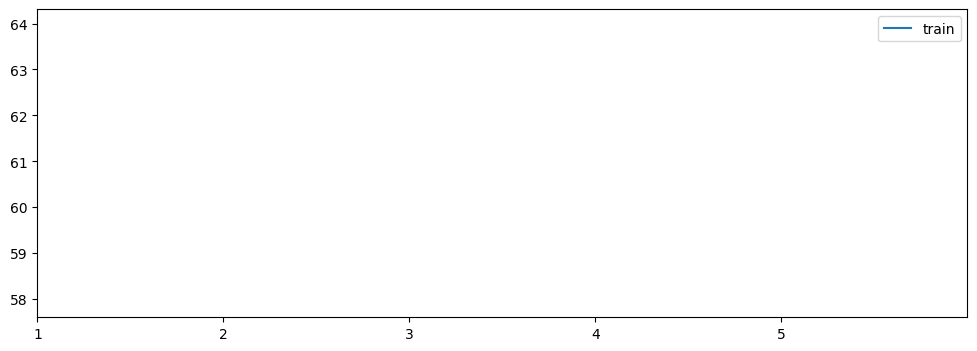

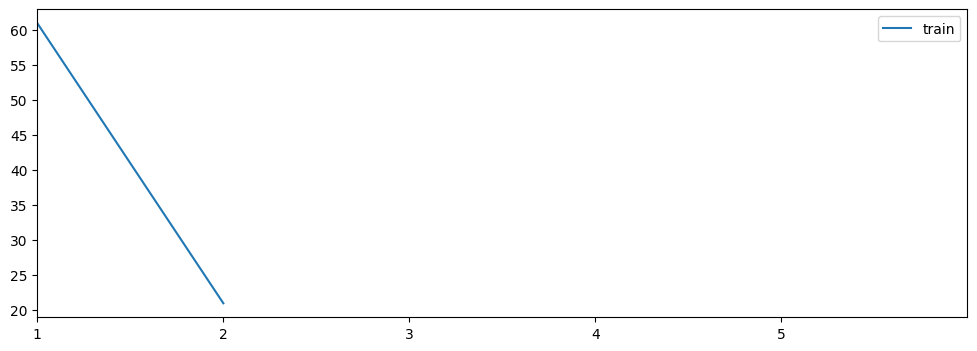

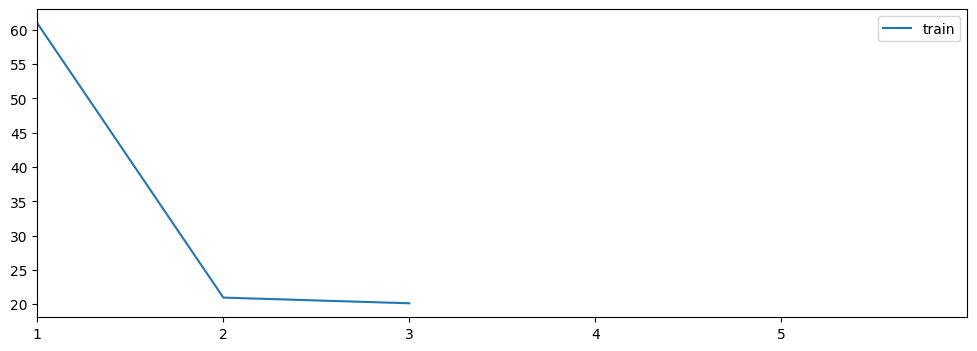

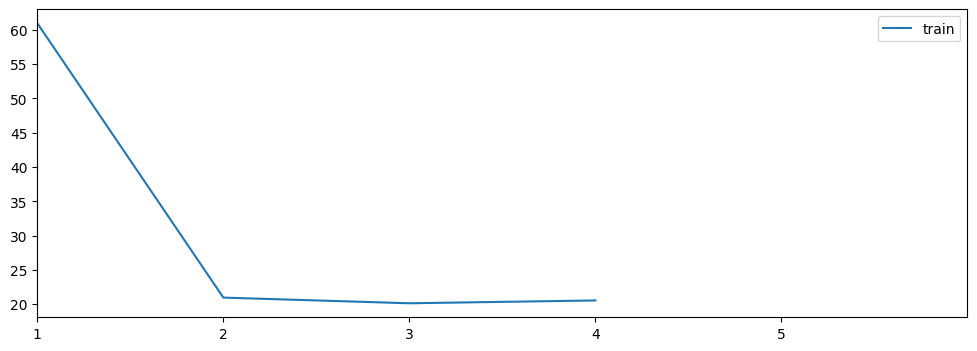

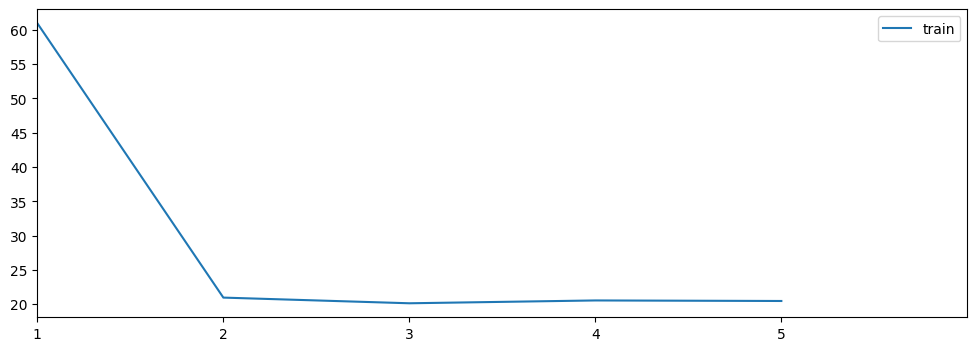

In [7]:
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model_instance_segmentation(3)
model = model.to(device)

if TRAIN_MODE:
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    t_loss = np.zeros(epochs)

    pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

    for epoch in pbar:

        train_loss = 0
        val_loss = 0
        model.train()

        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [
                {
                    k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()
                } for t in targets
            ]

            images = [image.permute(2, 0, 1) for image in images]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())


            optimizer.zero_grad()
            train_loss += losses.item()
            losses.backward()
            optimizer.step()

        t_loss[epoch - 1] = train_loss

        pl.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0, epochs, 1), range(1, epochs + 1, 1))

        display.display(pl.gcf())
        display.clear_output(wait=True)

    torch.save(model.state_dict(), 'buddha_dalmatian_weights_rcnn.pth')
else:
    # Cargar los pesos preentrenados
    model.load_state_dict(torch.load('buddha_dalmatian_weights_rcnn.pth'))

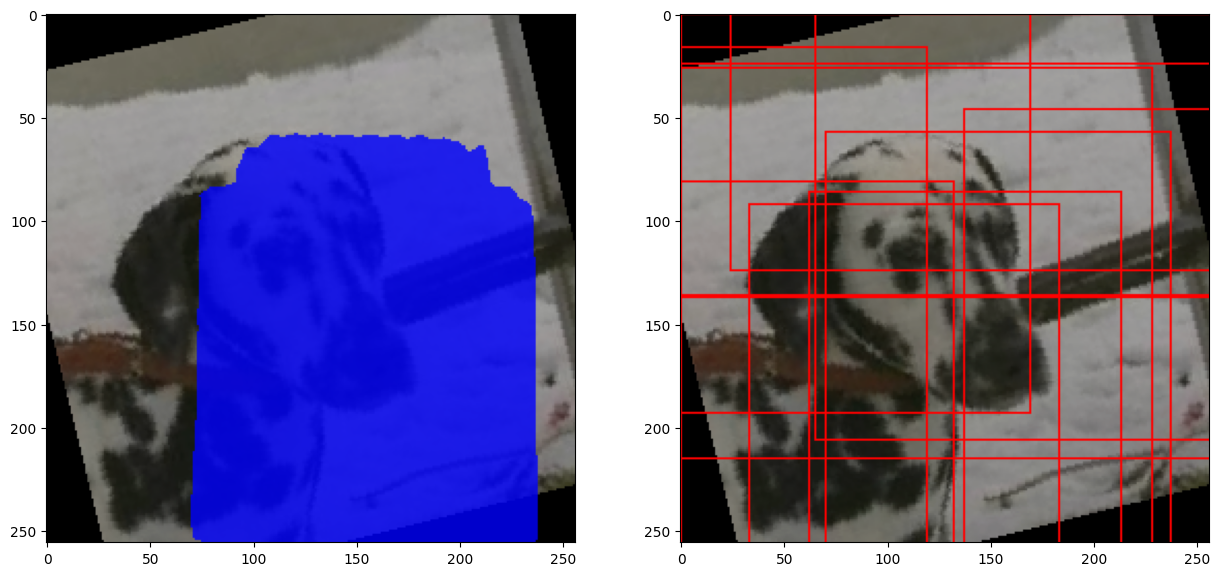

In [8]:
# Pasar el modelo a la GPU (si corresponde)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


num_batches_to_display = 2
batches_displayed = 0
model.eval()
images, targets = random.choice(list(test_loader))
images = list(image.to(device) for image in images)
targets = [
    {
        k: v.to(device) if isinstance(v, torch.Tensor) else v
        for k, v in t.items()
    } for t in targets
]

images = [image.permute(2, 0, 1) for image in images]
res = model(images)

drawn_boxes = draw_bounding_boxes(images[0], res[0]["boxes"], colors="red")
mask_superposed = (
    draw_segmentation_masks(
        images[0], masks=(res[0]["masks"][0, 0, :, :] > 0.2), alpha=0.8, colors="blue"
    )
    .detach()
    .cpu()
)
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(mask_superposed.permute(1, 2, 0))
ax[1].imshow(drawn_boxes.permute(1, 2, 0).cpu().numpy());
plt.show()

Como se puede apreciar a primera vista, queda claro que el modelo Mask-RCNN queda muy por detrás del YOLO. Como se puede ver, incluso con 50 epocas, los resultados no son suficientes como para considerarlos satisfactorios.

Además, Mask-RCNN queda muy por detrás en cuanto a velocidad con el YOLO. Para 50 epocas, vemos como el Mask-RCNN ha tardado 30 min y el YOLO menos de 1 min.

# Conclusión

Una vez vistos ejecutados todos los modelos, sacamos un par de conclusiones.

En cuanto a la clasificación, queda claro que por facilidad y por el tamaño de nuestro dataset, que conviene hacer un fine tunning de un modelo entrenado con muchisimas imagenes que crear uno propio desde 0. Esto se ha visto reflejado en el accuracy y en el tiempo, asi como en los ejemplos.

Por otro lado, en cuanto a los modelos de detección de imagenes, queda claro que el modelo que ha sobrevivido con el tiempo es el YOLO frente al Mask-RCNN, debido a su facilidad y a los muy buenos resultados dados, frente a unos resultados muy pobres del Mask-RCNN.

Tambien, en cuanto a la segmentación, creemos que el Mask-RCNN no ha cumplido con nuestras expectativas, dando unos resultados muy diferentes al objetivo.